<a href="https://colab.research.google.com/github/luisemiliani/Explore-UCSDB/blob/master/Exploring_UCSDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# So how many satellites are up there ?
##Exploring the UCS satellite database
>    Luis Emiliani, CENG. June 2020

Have you ever wondered how many satellites are above us ?

It is a question I get often, as I chat to people and the topic of my work in the frequency coordination and specturm domain at SES comes up.

So I thought I'd add to my story, and share with you a very good resource I use in my geostationary satellite communciations lectures, to illustrate just how many satellites are in operation above us.

The code below is required for initialization of the python notebook, modify at your own risk!

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

%load_ext google.colab.data_table

sns.color_palette("Set1", n_colors=8, desat=.5)

def set_bar_label(ax_ref, minval=1, orient='h'):
  for p in ax_ref.patches:
    if orient=='h':
      if p.get_width() >=minval:
        ax_ref.annotate('{}'.format(p.get_width()),xy=(p.get_x()+p.get_width()*1.05,p.get_y()*1.05),fontsize=9)
    else:
      for p in ax_ref.patches:
        if p.get_height() >=minval:
          ax_ref.annotate('{}'.format(p.get_height()),xy=(p.get_x()+0.4*p.get_width(), p.get_y() + p.get_height()*1.01),fontsize=9)


The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table




---


# The Union of Concerned Scientists (UCS) satellite database


The Satellite database, curated by the [Union of Concerned Scientists](https://www.ucsusa.org/), is an interesting compendium of data for operational  satellites.

The database contains information about satellites orbiting earth such as name, operator, manufacturer, country of registration, country where the operator is located, type of user (Civil, Commercial, Military), payload purpose (communications, earth observation), date of launch, orbit parameters, etc.
The database is updated every quarter and made available via the UCS website [here.](https://www.ucsusa.org/resources/satellite-database) 

I have used the database a few times, as part of my *Introduction to Geostationary Satellite Communiciations* lectures, to present basic numbers about the satellite services value chain (such as data on launchers, satellite manufacturers, satellite operators) and the space industry in general. 

In this project I will show a few ways in which Python and the Pandas module can be used to explore the database.

## First: load the database
The database is distributed in [CSV and excel format](https://www.ucsusa.org/resources/satellite-database). For the exercises that follow I will use the Excel version. Download the file to your computer.

To begin, we load the excel file containing the database into a Pandas dataframe. The excel file can be imported into the colab environment from your computer: execute the code in the next cell, and then use the *choose files* button and navigate to find the file you have downloaded.

In [4]:
uploaded = files.upload()

Saving UCS-Satellite-Database-4-1-2020.xls to UCS-Satellite-Database-4-1-2020.xls


Load it into a dataframe. Note that I am using prior knowledge of the column headers to map the *date of launch* column as the dataframe index.

In [5]:
UCSDB=pd.read_excel('UCS-Satellite-Database-4-1-2020.xls',index_col='Date of Launch',parse_dates=True,thousands=',')
UCSDB.index.name='Date of Launch'

To understand the dataframe we can explore the column names, data count and data type

In [6]:
UCSDB.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2670 entries, 2019-12-11 to NaT
Data columns (total 65 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Name of Satellite, Alternate Names  2666 non-null   object 
 1   Country/Org of UN Registry          2666 non-null   object 
 2   Country of Operator/Owner           2666 non-null   object 
 3   Operator/Owner                      2666 non-null   object 
 4   Users                               2666 non-null   object 
 5   Purpose                             2666 non-null   object 
 6   Detailed Purpose                    887 non-null    object 
 7   Class of Orbit                      2666 non-null   object 
 8   Type of Orbit                       2047 non-null   object 
 9   Longitude of GEO (degrees)          2666 non-null   float64
 10  Perigee (km)                        2666 non-null   float64
 11  Apogee (km)                     

## Then, clean it up
Very interesting data indeed, but also with a few issues :

*   Some missing dates in the Date of Launch column we used as index,
*   Missing data in some columns,
*   Empty columns (Unnamed, with zero non-null entries), resulting from comments and links to sources left in the excel sheet.

Let's explore the first and last couple of data rows,

In [7]:
UCSDB.head(2)

,"Name of Satellite, Alternate Names",Country/Org of UN Registry,Country of Operator/Owner,Operator/Owner,Users,Purpose,Detailed Purpose,Class of Orbit,Type of Orbit,Longitude of GEO (degrees),Perigee (km),Apogee (km),Eccentricity,Inclination (degrees),Period (minutes),Launch Mass (kg.),Dry Mass (kg.),Power (watts),Expected Lifetime (yrs.),Contractor,Country of Contractor,Launch Site,Launch Vehicle,COSPAR Number,NORAD Number,Comments,Unnamed: 27,Source Used for Orbital Data,Source,Unnamed: 30,Source.1,Source.2,Source.3,Source.4,Source.5,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65
Date of Launch,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-11,1HOPSAT-TD (1st-generation High Optical Perfor...,NR (3/20),USA,Hera Systems,Commercial,Earth Observation,Technology Development,LEO,Non-Polar Inclined,0.0,566.0,576.0,0.00072,36.9,96.08,22.0,NaN,NaN,0.5,Hera Systems,USA,Satish Dhawan Space Centre,PSLV,2019-089H,44589.0,Pathfinder for planned earth observation const...,NaN,JMSatcat/3_20,https://spaceflightnow.com/2019/12/11/indias-5...,https://www.herasys.com/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-29,3Cat-1,NR,Spain,Universitat Politècnica de Catalunya,Civil,Technology Development,NaN,LEO,NaN,0.0,476.0,500.0,0.00175,97.4,95.00,4.0,NaN,NaN,NaN,Universitat Politècnica de Catalunya,Spain,Satish Dhawan Space Centre,PSLV,2018-096K,43728.0,Student built.,NaN,Estimated,https://spaceflightnow.com/2018/11/29/indian-r...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
UCSDB.tail(2)

,"Name of Satellite, Alternate Names",Country/Org of UN Registry,Country of Operator/Owner,Operator/Owner,Users,Purpose,Detailed Purpose,Class of Orbit,Type of Orbit,Longitude of GEO (degrees),Perigee (km),Apogee (km),Eccentricity,Inclination (degrees),Period (minutes),Launch Mass (kg.),Dry Mass (kg.),Power (watts),Expected Lifetime (yrs.),Contractor,Country of Contractor,Launch Site,Launch Vehicle,COSPAR Number,NORAD Number,Comments,Unnamed: 27,Source Used for Orbital Data,Source,Unnamed: 30,Source.1,Source.2,Source.3,Source.4,Source.5,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65
Date of Launch,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.nasaspaceflight.com/2012/01/china-o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://spaceflights.news/?p=35647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As noted, the Excel version of the database contains a few columns with comments and a few missing data points. 
For our work, I will drop the unnecessary last rows, which do not contain data in the '*Name of Satellite, Alternate Names*' column, and also all columns which do not contain more than 5 valid data points (that is, at least 5 rows with valid data in the column), and, after removing problematic rows with missing Dates of Launch, we will sort the index (Date of Launch) chronologically :

In [9]:
UCSDB = UCSDB[ UCSDB['Name of Satellite, Alternate Names'].notna() ]
UCSDB.dropna( axis='columns', thresh=5, inplace=True)
UCSDB.sort_index(axis=0, inplace=True, ascending=True)
#print(UCSDB.index)
UCSDB.head(2)

,"Name of Satellite, Alternate Names",Country/Org of UN Registry,Country of Operator/Owner,Operator/Owner,Users,Purpose,Detailed Purpose,Class of Orbit,Type of Orbit,Longitude of GEO (degrees),Perigee (km),Apogee (km),Eccentricity,Inclination (degrees),Period (minutes),Launch Mass (kg.),Dry Mass (kg.),Power (watts),Expected Lifetime (yrs.),Contractor,Country of Contractor,Launch Site,Launch Vehicle,COSPAR Number,NORAD Number,Comments,Source Used for Orbital Data,Source,Unnamed: 30,Source.1,Source.2,Source.3,Source.4,Source.5
Date of Launch,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1974-11-15,Amsat-Oscar 7 (AO-7),USA,USA,AMSAT-NA,Civil,Communications,NaN,LEO,Polar,0.00,1440.0,1459.0,0.001215,101.40,114.90,29.0,NaN,NaN,NaN,Amsat-NA,USA,Vandenberg AFB,Delta 2310,1974-089B,7530.0,American amateur radio satellite.,www.satellitedebris.net 12/12,http://www.amsat.org/amsat-new/satellites/stat...,NaN,http://www.emilyshouse.com/experthams/ao7/main...,NaN,NaN,NaN,NaN
1988-09-29,"TDRS-3 (Tracking and Data Relay Satellite, TDR...",USA,USA,National Aeronautics and Space Administration ...,Government,Communications,Optical Imaging,GEO,NaN,84.41,35693.0,35878.0,0.002194,11.53,1436.06,3180.0,1600,1800,10.0,TRW Defense and Space Systems Group,USA,Cape Canaveral,Space Shuttle (STS 26),1988-091B,19548.0,Backup; still partially operational.,JM/12_08,NaN,NaN,http://www.boeing.com/defense-space/space/bss/...,http://nssdc.gsfc.nasa.gov/database/MasterCata...,http://nmsp.gsfc.nasa.gov/tdrss/tconst.html,NaN,NaN


After sorting, we see that the oldest satellite recorded as active in the UCSDB is [Amsat-Oscar 7 (AO7)](https://en.wikipedia.org/wiki/AMSAT-OSCAR_7), and that the newest entry in the database corresponds to [AEHF-6](https://en.wikipedia.org/wiki/Advanced_Extremely_High_Frequency)


In [10]:
print(UCSDB.iloc[0,0:5])

Name of Satellite, Alternate Names    Amsat-Oscar 7 (AO-7)
Country/Org of UN Registry                             USA
Country of Operator/Owner                              USA
Operator/Owner                                    AMSAT-NA
Users                                                Civil
Name: 1974-11-15 00:00:00, dtype: object


In [11]:
UCSDB.iloc[-1,0:5]

Name of Satellite, Alternate Names    AEHF-6 (Advanced Extremely High Frequency sate...
Country/Org of UN Registry                                                    NR (4/20)
Country of Operator/Owner                                                           USA
Operator/Owner                                                            US Air Force 
Users                                                                          Military
Name: 2020-03-26 00:00:00, dtype: object

In this update of the database, the title of oldest GEO satellite for commercial purposes, still in operation, goes to [ASTRA 1D](https://en.wikipedia.org/wiki/Astra_1D).

In [12]:
print(UCSDB[(UCSDB['Class of Orbit']=='GEO') & (UCSDB['Users']=='Commercial')].iloc[0,0:8].to_string())

Name of Satellite, Alternate Names         Astra 1D 
Country/Org of UN Registry                Luxembourg
Country of Operator/Owner                 Luxembourg
Operator/Owner                              SES S.A.
Users                                     Commercial
Purpose                               Communications
Detailed Purpose                                 NaN
Class of Orbit                                   GEO


After this initial exploration, we can answer some interesting questions regarding satellites in space.

# Country-level exploration

By looking at the country of registration and country of operator, we could gauge the activity of a country's space sector. 

*Note: We should remove Not registered (NR) entries from the column 'Country/Org of UN Registry' before the next cell.*

In [72]:
# Determine number of satellites per country of registration and operator, for all countries
# The series returned contains the sum of satellites for all countries, sorted by value

nbr_sats_per_cnt_reg=UCSDB['Country/Org of UN Registry'].value_counts()
nbr_sats_per_cnt_op=UCSDB['Country of Operator/Owner'].value_counts()

The variables **nbr_sats_per_reg** and **nbr_sats_per_op** contain the number of satellites per country of registration and per country of operator, sorted by number in ascending order. As the number of countries is rather large, the cell below explores the top five of each variable:

In [14]:
# Number of satellites based on Country of Registry, ranked for top 5
print('Satellite total count (top 5), per country of UN registration')
print('-------------------------------------------------------------')
UCSDB[UCSDB['Country/Org of UN Registry'].str.contains("NR")==0]['Country/Org of UN Registry'].value_counts()[:5]


Satellite total count (top 5), per country of UN registration
-------------------------------------------------------------


USA               863
China             237
Russia            157
United Kingdom    133
Japan              67
Name: Country/Org of UN Registry, dtype: int64

In [15]:
# Number of satellites based on Country of Operator/Owner, ranked for top 5
print('Satellite total count (top 5), per country of Operator')
print('------------------------------------------------------')
UCSDB['Country of Operator/Owner'].value_counts()[:5]

Satellite total count (top 5), per country of Operator
------------------------------------------------------


USA               1308
China              356
Russia             167
United Kingdom     130
Japan               78
Name: Country of Operator/Owner, dtype: int64

Graphically,

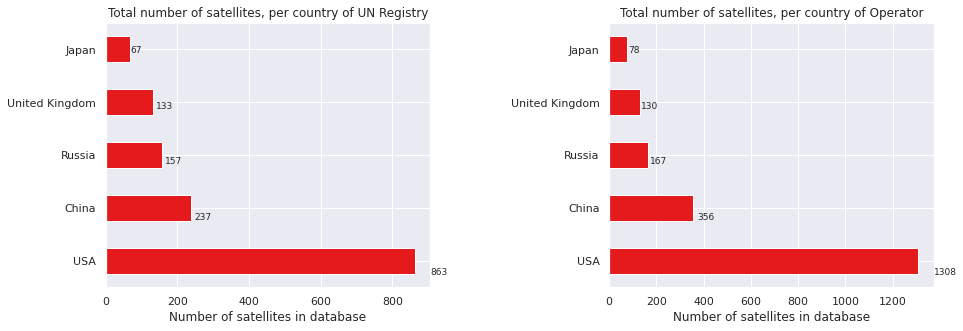

In [92]:
# a bar plot for the top five countries, 
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.tight_layout(pad=0.0)
fig.set_size_inches(8,4)
ax1=UCSDB[UCSDB['Country/Org of UN Registry'].str.contains("NR")==0]['Country/Org of UN Registry'].value_counts()[:5].plot(kind='barh',ax=ax[0])
ax2=nbr_sats_per_cnt_op[0:5].plot(kind='barh')
plt.subplots_adjust(right=1.5,wspace=0.55)
# set a legend, title
ax1.set_xlabel('Number of satellites in database')
ax1.set_title('Total number of satellites, per country of UN Registry')
ax2.set_xlabel('Number of satellites in database')
ax2.set_title('Total number of satellites, per country of Operator')

#annotate
set_bar_label(ax1)
set_bar_label(ax2)


# Which orbits are most frequently used ?

The database includes information 
on orbit type, and satellite user type. 

A histogram can provide us information on the number of satllites per orbit class,



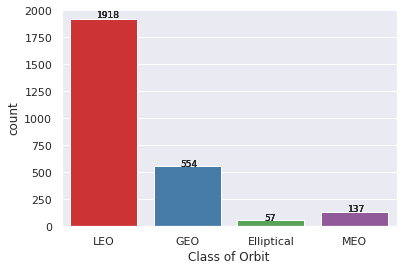

In [93]:
axClass = sns.countplot(UCSDB['Class of Orbit'])
set_bar_label(axClass,minval=1, orient='v')

Keeping in mind the information regarding types of users, we can determine for example, 

*how many communication satellites for commercial purposes are in space, grouped per class of orbit ?*

We can present the data grouped by columns "Class of Orbit" and "Users". Aggregating by *count* returns the total per category:

In [18]:
print(UCSDB.groupby(['Class of Orbit','Users'])['Name of Satellite, Alternate Names'].count().to_string())


Class of Orbit  Users                         
Elliptical      Civil                                3
                Commercial                           5
                Government                          21
                Government/Civil                     3
                Military                            24
                Military/Civil                       1
GEO             Commercial                         311
                Commercial                           1
                Commercial/Government                1
                Commercial/Military                  2
                Government                          96
                Government/Civil                     4
                Government/Commercial               11
                Government/Commercial/Military       1
                Government/Military                  3
                Military                            89
                Military/Commercial                 14
                Mi

Looking at the satellites for commercial use, we see 304 GEO satellites, 105 MEO satellites, and 1195 LEO satellites.

In [19]:
gb=UCSDB.groupby(['Class of Orbit','Users'])
#compute the total per class of orbit, using direct computation methods. Note that this can also be accomplished through filter and logical indexing
nbr_GEO_comm_sats = gb.get_group(('GEO','Commercial'))['Name of Satellite, Alternate Names'].count() + \
              gb.get_group(('GEO','Commercial/Military'))['Name of Satellite, Alternate Names'].count() + \
              gb.get_group(('GEO','Commercial/Government'))['Name of Satellite, Alternate Names'].count()

nbr_MEO_comm_sats = gb.get_group(('MEO','Commercial'))['Name of Satellite, Alternate Names'].count() + \
              gb.get_group(('MEO','Military/Commercial'))['Name of Satellite, Alternate Names'].count()

nbr_LEO_comm_sats = gb.get_group(('LEO','Commercial'))['Name of Satellite, Alternate Names'].count() + \
              gb.get_group(('LEO','Commercial/Civil'))['Name of Satellite, Alternate Names'].count() + \
              gb.get_group(('LEO','Government/Commercial'))['Name of Satellite, Alternate Names'].count() +\
              gb.get_group(('LEO','Military/Commercial'))['Name of Satellite, Alternate Names'].count()

print('Totals by class of orbit ')
print('-------------------------------------------------')
print('Number of GEO satellites for commercial use: ', nbr_GEO_comm_sats)
print('Number of MEO satellites for commercial use: ', nbr_MEO_comm_sats)
print('Number of LEO satellites for commercial use: ', nbr_LEO_comm_sats)


Totals by class of orbit 
-------------------------------------------------
Number of GEO satellites for commercial use:  314
Number of MEO satellites for commercial use:  105
Number of LEO satellites for commercial use:  1195


# Where are satellites launched from ?

Exploring the 'Launch Site' column, we see that the site from where the most satellites have been launched (for any purpose) is Cape Canaveral, followed by Baikonur Cosmodrome:

List of top 10 launch sites, sorted by number of satellites launched
--------------------------------------------------------------------
Cape Canaveral                     603
Baikonur Cosmodrome                360
Satish Dhawan Space Centre         334
Guiana Space Center                276
Vandenberg AFB                     243
Jiuquan Satellite Launch Center    145
Xichang Satellite Launch Center    119
Plesetsk Cosmodrome                113
Taiyuan Launch Center              111
Vostochny Cosmodrome                64


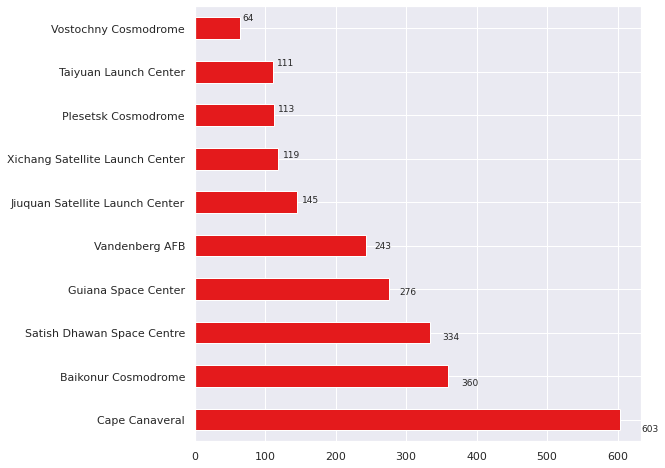

In [94]:
nbr_sats_per_launch_site=UCSDB['Launch Site'].value_counts()
print('List of top 10 launch sites, sorted by number of satellites launched')
print('--------------------------------------------------------------------')
print(nbr_sats_per_launch_site[0:10].to_string())
axTen = UCSDB['Launch Site'].value_counts()[:10].plot(kind='barh', figsize=(8,8))
#axTen = sns.countplot(y=UCSDB['Launch Site'],order=pd.value_counts(UCSDB['Launch Site']).iloc[:10].index)
set_bar_label(axTen, orient='h')

## And which vehicles are used to launch them ?
We can also repeat the principle for the launch vehicles, but note that 
* several vehicles launch from the same site (such as from Cape Canaveral) 
* launch vehicles can launch from different sites (such as the Falcon 9, from Vandenberg or Cape Canaveral, depending on mission)

In [21]:
nbr_sats_per_launch_vehicle=UCSDB['Launch Vehicle'].value_counts()
print('List of launchers by number of satellites launched total, top 10')
print('---------------------------------------------------------------')
print(nbr_sats_per_launch_vehicle[0:10])

List of launchers by number of satellites launched total, top 10
---------------------------------------------------------------
Falcon 9         539
PSLV             254
Soyuz 2.1a       123
Atlas 5           97
Ariane 5          87
Dnepr             86
Long March 2D     79
Soyuz-2.1b        79
Ariane 5 ECA      73
Proton M          71
Name: Launch Vehicle, dtype: int64


It is quite telling : Falcon 9, a relatively new launch vehicle ([its 10th birthday just passed](https://www.space.com/spacex-first-falcon-9-rocket-launch-10-years.html#:~:text=SpaceX's%20famous%20Falcon%209%20rocket,Air%20Force%20Station%20in%20Florida.)), has already supported the launch of more satellites than the Ariane and Proton M vehicles *combined*. Which is not a surprise, given how many Starlink satellites are launched together.

In [22]:
BySite_group = UCSDB.groupby(['Launch Site','Launch Vehicle']) 
nbr_Starlink_launched_from_cc = BySite_group.get_group(('Cape Canaveral','Falcon 9'))['Name of Satellite, Alternate Names'].str.contains('tarlink').sum()
nbr_NonStarlink_launched_from_cc = BySite_group.get_group(('Cape Canaveral','Falcon 9'))['Name of Satellite, Alternate Names'].str.contains('^((?!tarlink).)*$').sum()

print(' - number of Starlink satellites launched with Falcon 9 from Cape Canaveral : ', nbr_Starlink_launched_from_cc )
print(' - number of non-Starlink satellites launched with Falcon 9 from Cape Canaveral : ', nbr_NonStarlink_launched_from_cc )
print(' - total launched from Cape Canaveral using Falcon 9: ', nbr_Starlink_launched_from_cc+nbr_NonStarlink_launched_from_cc)


 - number of Starlink satellites launched with Falcon 9 from Cape Canaveral :  354
 - number of non-Starlink satellites launched with Falcon 9 from Cape Canaveral :  48
 - total launched from Cape Canaveral using Falcon 9:  402


/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Now,  a closer look at the first 15 satellites launched using Falcon 9.

SES-8 was the [first commercial GEO launch for Spacex](https://www.ses.com/press-release/launch-success-ses-8-satellite-board-spacexfalcon-9)

In [97]:
#To modify the code to see, say, only the first 10 launches, add [0:11] after the columns names in the print () function.
ByLaunchSite = UCSDB.groupby(['Launch Vehicle'])
print(ByLaunchSite.get_group('Falcon 9')[['Launch Site','Name of Satellite, Alternate Names']][0:16])

                   Launch Site                 Name of Satellite, Alternate Names
Date of Launch                                                                   
2013-09-29      Vandenberg AFB  Cassiope (CAScade SmallSat and Ionospheric Pol...
2013-12-03      Cape Canaveral                                              SES-8
2014-01-06      Cape Canaveral                                          Thaicom-6
2014-07-14      Cape Canaveral                                 ORBCOMM OG2 FM-107
2014-07-14      Cape Canaveral                                 ORBCOMM OG2 FM-103
2014-07-14      Cape Canaveral                                 ORBCOMM OG2 FM-109
2014-08-05      Cape Canaveral                                          AsiaSat-8
2014-09-07      Cape Canaveral                              AsiaSat-6 (Thaicom-7)
2015-03-02      Cape Canaveral                                Eutelsat 115 West B
2015-03-02      Cape Canaveral                                            ABS-3A 
2015-04-27      

# Exploring operators
We can focus for an instant on the number of satellite operators flying satellites for commercial purposes,


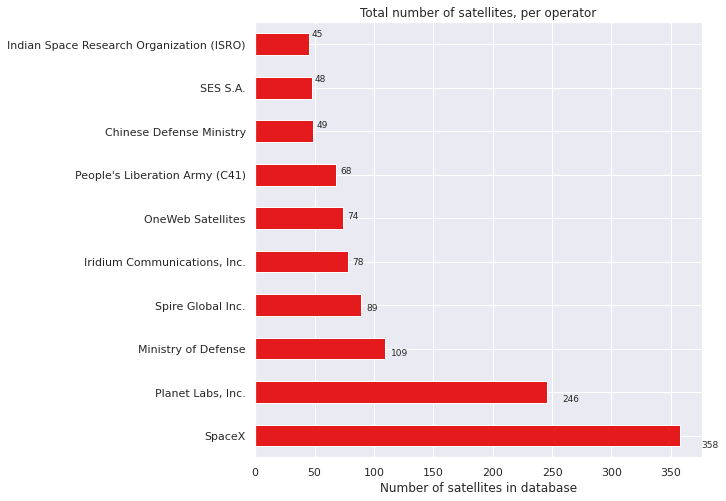

In [98]:
nbr_sats_per_op=UCSDB['Operator/Owner'].value_counts()
# a bar plot for the top ten operators, by number of satellites, 
axOp=UCSDB['Operator/Owner'].value_counts()[:10].plot(kind='barh', figsize=(8,8))
#axOp = sns.countplot(y=UCSDB['Operator/Owner'],order=pd.value_counts(UCSDB['Operator/Owner']).iloc[:-10].index)
#annotate bars,
set_bar_label(axOp)
# set a legend, title
axOp.set_xlabel('Number of satellites in database')
_= axOp.set_title('Total number of satellites, per operator')


Well, no suprise here : Planet Labs and Spacex lead the list by number of satellites. 
What is interesting here is the impact that *#newspace* has had in the overall ecosystem. Four of the operators with the most satellites are relatively new, and two of them are in the earth-observation domain.

Shifting the focus to GEO operators, with emphasis in commercial satcoms,

There are 74 GEO satcomm operators in the list
----------------------------------------------


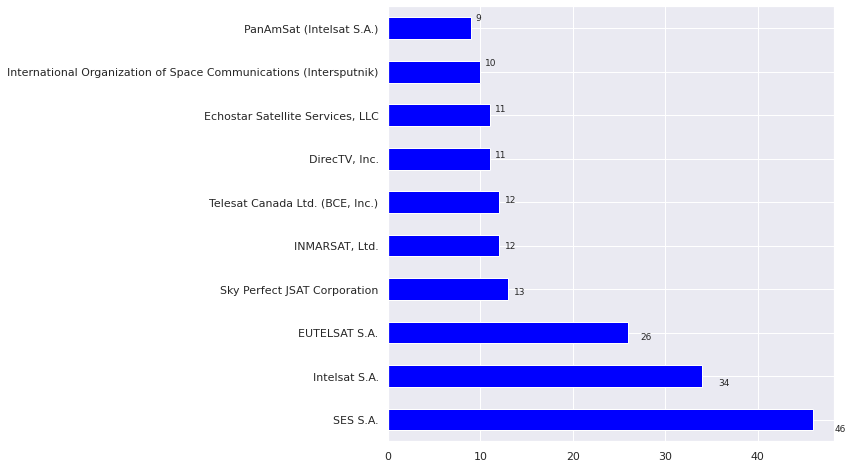

In [104]:

#A detailed look on GSO operators, with a commercial focus in the telecommunications domain, returns the following fleet sizes
#first we build alist with the operator's names,
GSO_comm_ops = np.unique(UCSDB['Operator/Owner'][(UCSDB['Users'] == 'Commercial') & (UCSDB['Purpose'] == 'Communications')& (UCSDB['Class of Orbit'] == 'GEO')])
#the length of the list is 74, meaning there are 74 operators meeting the three conditions set in our query above.
print('There are {} GEO satcomm operators in the list'.format(len(GSO_comm_ops)))
print('----------------------------------------------')

#alternatively, we can use a more complex but compact approach, as we did in the figures above, using Vaue_counts()
ax4 = UCSDB['Operator/Owner'][(UCSDB['Users'] == 'Commercial') & (UCSDB['Purpose'] == 'Communications') \
                              & (UCSDB['Class of Orbit'] == 'GEO')].value_counts()[0:10].plot(kind='barh', color='blue',figsize=(8,8))
set_bar_label(ax4)



---


The main issue with the analysis above is that a satellite operator's name appears several times, in different form, for example in cases where it leased a payload to a service provider or shares the platform with another operator.
For example, a satellite might be assigned to an operator as

*   Telesat Canada, 
*   Telesat Canada Ltd. (BCE, Inc.)/APT Satellite Holdings Ltd.

which will be recorded as separate operators. Moreover, merged entities appear as separate (see Panamsat / Intelsat or SES / O3B).

Let's make a more specific search, for what are known as the "Big Four" FSS operators : Eutelsat, Intelsat, SES, Telesat, looking for any satellite which has those companies listed as operators in any combination in the string, and, in the case of SES, adding the O3B constellation in MEO orbit.

In [26]:
#IS_DF=UCSDB[UCSDB['Operator/Owner'].str.contains('ntelsat') & UCSDB['Users'].str.contains('Commercial')]
IS_count=np.sum(UCSDB['Operator/Owner'].str.contains('intelsat',case=False) & UCSDB['Users'].str.contains('Commercial'))
EUT_count=np.sum(UCSDB['Operator/Owner'].str.contains('eutelsat',case=False) & UCSDB['Users'].str.contains('Commercial'))
TEL_count=np.sum(UCSDB['Operator/Owner'].str.contains('telesat',case=False) & UCSDB['Users'].str.contains('Commercial'))
SES_count=np.sum(UCSDB['Operator/Owner'].str.contains('ses',case=False) & UCSDB['Users'].str.contains('Commercial')) + \
          np.sum(UCSDB['Operator/Owner'].str.contains('o3b',case=False) & UCSDB['Users'].str.contains('Commercial'))

print('UCSDB contains : ')
print('---------------------------')
print(' {} Eutelsat satellites'.format(EUT_count))
print(' {} Intelsat satellites'.format(IS_count))
print(' {} SES/O3B satellites'.format(SES_count))
print(' {} Telesat satellites'.format(TEL_count))


UCSDB contains : 
---------------------------
 33 Eutelsat satellites
 51 Intelsat satellites
 72 SES/O3B satellites
 15 Telesat satellites


## Where are GEO communication satellites located ?
Filtering the data based on GEO orbit and communications use, and making a histogram of the valid data points in the resulting set, gives us an idea of the distribution of satellites along the GEO orbit,


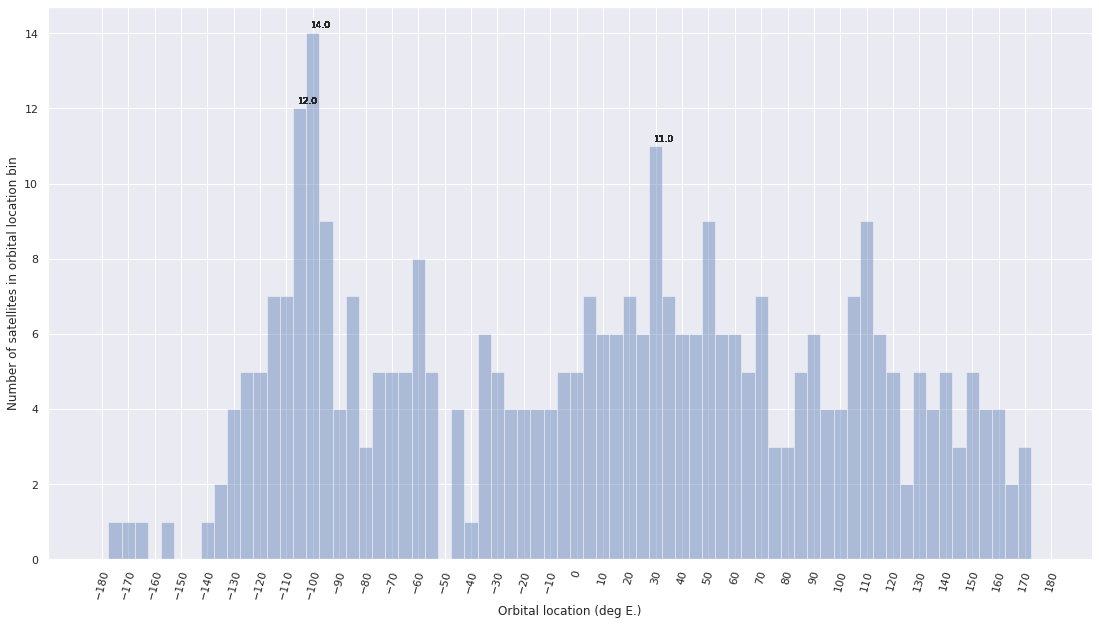

In [27]:
#extract all data points for GEO orbit, look at the longitude column
flt_id = (UCSDB['Class of Orbit'] == 'GEO') & (UCSDB['Users'].str.contains('commercial', case = False))
GEO_long = UCSDB[ flt_id ]['Longitude of GEO (degrees)'].astype(float)
#correct longitudes to fall in the range (-180,180)
GEO_long[ GEO_long > 180] = GEO_long[ GEO_long > 180] - 360
#make a histogram of the longitude data points, 
#histogram intervals definition and xticks locations.
bin_edges = np.arange(-180,185,5)-2.5 #every five degrees.
x_axis_ticks = np.arange(-180,190,10)
# create figure canvas and axes
fig, ax5 = plt.subplots(figsize=[15,8])
fig.tight_layout(pad=0.0)

#plot.
_ = sns.distplot(GEO_long,bins=bin_edges,kde=False,axlabel='Orbital location (deg E.)',ax=ax5) 
_ = plt.xticks(x_axis_ticks,rotation=75)
_ = plt.xlabel('Orbital location (deg E.)')
_ = plt.ylabel('Number of satellites in orbital location bin')

set_bar_label(ax5, minval=10, orient='v')
#in case you want to explore a swarmplot,
#_ = sns.swarmplot(GEO_long, ax=ax6, orient = 'v', color='g')



With the interval definitions above (and feel free to change them), there are three orbital locations with 10 or more satellites, 

* around -100E, center of the US arc, home of DTH and cable distribution
* around -60E, home of the latin-america and Brazil video neighborhoods, 
* around 30E, home of a few east-european video neighborhoods

The European video hotspots, 13, 16 and 19.2E, account for about 18 satellites total. 


# Exploring numbers per contractor

Finally, given the information in the "Contractor" column, it is also possible to assess the number of spacecraft built by each manufacturer. Note that, just as with the operator name, spacecraft built by a manufacturer today may need to be aggregated from various entries.

The code cell below extracts the data, without attempting to merge manufacturers, and presents a bar plot for the top 15 results by number of satellites.

Once again: amazing to see the number of units corresponding to SpaceX, once the time scales of the deployment of those units is considered. An example of serial almost mass-production of space hardware.

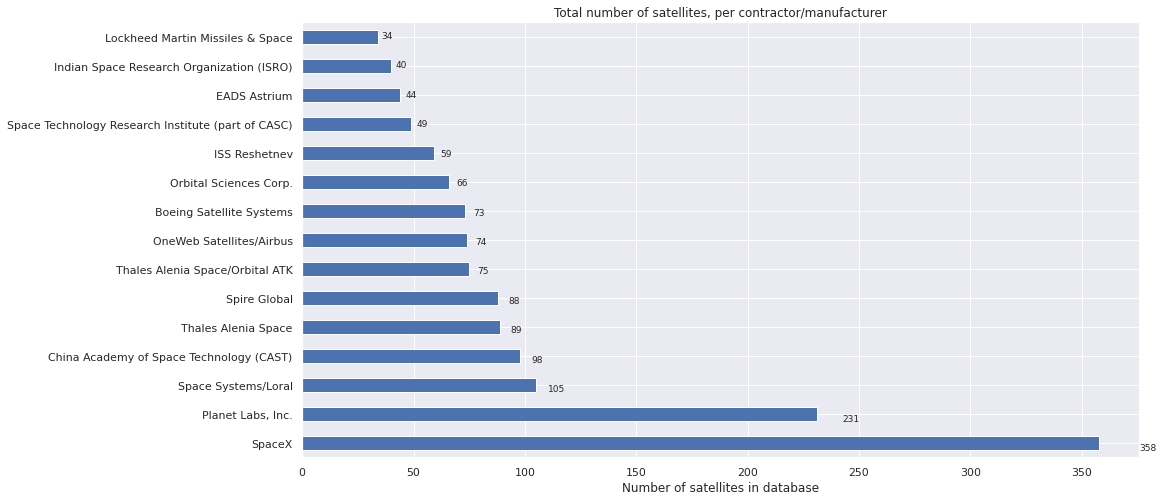

In [28]:
nbr_sats_per_op=UCSDB['Contractor'].value_counts()
# a bar plot for the top five operators, by number of satellites, 
fig, ax6 = plt.subplots(figsize=[15,8])
ax6=UCSDB['Contractor'].value_counts()[:15].plot(kind='barh')
#annotate bars,
set_bar_label(ax6)
# set a legend, title
plt.xlabel('Number of satellites in database')
plt.title('Total number of satellites, per contractor/manufacturer')
plt.show()

# Navigation systems
Considering the recent news regarding [China's BEIDOU system](https://www.cnbc.com/2020/06/23/beidou-china-completes-rival-to-the-us-owned-gps-system.html), let's have a look at the size of three navigation constellations : the US's GPS system (DoD/US Air Force GPS system), Europe's GALILEO system and China's BEIDOU.

To count how many satellites are there in each constellation, i will do a string search on the name, and count the matches. This will capture any satellite, regardless of orbit (the Beidou system has satellites in MEO and GEO orbit):

In [37]:
DOD_GPS = UCSDB['Name of Satellite, Alternate Names'].str.contains('navstar gps',case=False).sum()
EU_GALILEO = UCSDB['Name of Satellite, Alternate Names'].str.contains('galileo',case=False).sum()
CH_BEIDOU = UCSDB['Name of Satellite, Alternate Names'].str.contains('beidou',case=False).sum()
print('Count of operational satellites (APR-2020) in three navigation constellations:')
print('-----------------------------------------------------------------------------')
print('US DoD GPS    : {} satellites '.format(DOD_GPS))
print('EU GALILEO    : {} satellites '.format(EU_GALILEO))
print('CHINA BEIDOU  : {} satellites '.format(CH_BEIDOU))


Count of operational satellites (APR-2020) in three navigation constellations:
-----------------------------------------------------------------------------
US DoD GPS    : 33 satellites 
EU GALILEO    : 26 satellites 
CHINA BEIDOU  : 49 satellites 




---


# Closing thoughts

These are but a few of the many ways we can slice and cut the data in the UCSDB to get some insight into the evolution of satellites in operation today.

As additional exercises, we could explore further the earth observation and imaging sector, and companies such as [Spire](https://spire.com/) and [planet](https://www.planet.com/), or the explosive growth of SpaceX in the launch and communications domain, looking for example at the evolution of the number of launches per year since the first launch.

My intention with this notebook was to illustrate the various ways that the data can be explored and, hopefully, to pique your interest. Space is definitely a place where we do extraordinary things, to bring you amazing experiences everywhere on earth.


---


                                                    Luis Emiliani, 2020.




